# 1. Pre-steps

## 1.1 Import the necessary packages

In [175]:
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

## 1.2 Import the required dataset

In [176]:
df = pd.read_csv("data.csv",encoding = 'unicode_escape')
df['MOD_TRANS_CONV_TEXT'] = df['TRANS_CONV_TEXT']
df = df[['Patient_Tag', 'MOD_TRANS_CONV_TEXT']]
df.head()

,Patient_Tag,MOD_TRANS_CONV_TEXT
0,0,I don't disagree with you in principle. I'm ju...
1,1,I am always dizzy I get dizzy standing up so I...
2,0,Axelle/Bauer-Griffin/FilmMagic(NEW YORK) -- Qu...
3,1,I am 17 and I have been throwing up for about ...
4,0,Quote: Originally Posted by Boyan Silyavski Wa...


## 1.3 View text

The text documents consists of heart-failure related conversations extracted from various platforms.
It is required to build an intelligent workflow that extracts patient conversations from the entire group of documents. The problem is of supervised learning type as the conversations have been tagged beforehand manually.

In [177]:
# Non-patient conversation
df['MOD_TRANS_CONV_TEXT'][0]

'I don\'t disagree with you in principle. I\'m just saying that Entresto has been a major failure of Novartis commercial organisation. They (Novartis) were totally exposed at Q1 call. With reimbursement issues being resolved, the true underlying problem with Entresto was unveiled: Novartis failed to create the demand for the drug. Their disease-awareness campaign in the US (the drowning man) was incredibly poor (fear- and panic-inducing). What is more, they advertised the wrong condition. They were raising awareness of life-threatening ACUTE heart failure instead of CHRONIC heart failure, for which Entresto is indicated. Entresto has nothing to do with the treatment of acute heart failure. If that was not due to their shocking lack of knowledge of the disease area, it can only be explained as a conscious misleading of patients. They managed to alienate medical community, advocacy groups and top KOLs, including their own principal investigator in Entresto trials who publicly expressed h

In [178]:
# Patient conversations
df['MOD_TRANS_CONV_TEXT'][1]

"I am always dizzy I get dizzy standing up so I have made myself get up slow , I am dizzy when I turn around or turn my head so again I do these slow. I check my blood pressure every day and its usually around 94_ 113 / 65 _78 and have been told that's normal. In England we have a fantastic hospital called Christies which is a cancer hospital but I haven't heard of a hospital that is just for hearts so Monday I'm going to make it my mission to find out if we have one or not."

## 1.4 Get percentage distribution of each class

In [179]:
percentage_df = pd.DataFrame()
class_0 = round((len(df)-np.sum(df['Patient_Tag']==1))*100/len(df),2)
class_1 = round(np.sum(df['Patient_Tag'])*100/ len(df),2)
percentage_df['Percentage (%)'] = [class_0, class_1]
percentage_df['Class']= [0,1]
percentage_df.index = percentage_df['Class']
percentage_df = percentage_df[['Percentage (%)']]
percentage_df

,Percentage (%)
Class,
0,79.26
1,20.74


It can be clearly observed that the dataset is highly imbalanced. (80:20)

# 2. Pre-process data



## 2.1 Data Cleaning

It is necessary to bring the text documents into a suitable format by removal of noisy elements.
Different symbols, stop words, upper case characters are being removed. 
Stemming is performed to get the words to their base form.

In [180]:
tokenizer=RegexpTokenizer(r'\w+|\.')
stop_words=set(stopwords.words("english"))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    text = text.strip().lower()
    text = ''.join([i for i in text if not i.isdigit()])
    filters='!"\'#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    return text

In [181]:
df['MOD_TRANS_CONV_TEXT'] = df['MOD_TRANS_CONV_TEXT'].apply(lambda x : clean_text(str(x)))
df['MOD_TRANS_CONV_TEXT'] = df['MOD_TRANS_CONV_TEXT'].apply(lambda x : tokenizer.tokenize(str(x)))
df['MOD_TRANS_CONV_TEXT'] = df['MOD_TRANS_CONV_TEXT'].apply(lambda x : [w for w in x if not w in stop_words])
ps=PorterStemmer()
df['MOD_TRANS_CONV_TEXT'] = df['MOD_TRANS_CONV_TEXT'].apply(lambda l : [ps.stem(w) for w in l])
df['MOD_TRANS_CONV_TEXT'] = df['MOD_TRANS_CONV_TEXT'].apply(lambda x : " ".join(tokenizer.tokenize(str(x))))
corpus=df['MOD_TRANS_CONV_TEXT'].tolist()


## 2.2 Perform train-test split

A 70:30 split is being performed.

In [182]:
X = corpus
y = df['Patient_Tag'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.30, random_state=2)

# 3. Exploratory Data Analysis
It is required to characterize the importance of a particular word to a document. The TFIDF (term frequency–inverse document frequency) is a metric that defines how unique a word is to a document within the entire set of documents. A score is assigned to each word for every document. It is expected that certain set of words would be unique to patient conversations. The computed scores then act as feature vectors for the modelling exercise since algorithms cannot directly work with raw textual data.

In [183]:
# Each word is assigned a score proportional to how unique the word is in the entire set of documents.
# These scores are represented in a matrix format. 
tfidf_vectorizer = TfidfVectorizer(use_idf = True)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_train = X_train.toarray()


Now, calculate the mean TFIDF scores for documents falling within each category and list out the top 25 words.

In [184]:
def mean_tfidf(X, y, document_category = 0):
    avg_df = pd.DataFrame()
    avg_df['']= tfidf_vectorizer.get_feature_names()
    avg_df = avg_df.set_index('')
    for elem in y_train:
        index_list = [i for i in range(len(y_train)) if y[i] == document_category] 
    top50_lst =[]
    for idx in index_list:
        temp_df = pd.DataFrame(X[idx], index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"+str(idx)])
        avg_df = avg_df.join(temp_df["tfidf"+str(idx)])
    avg_df['tfidf'] = avg_df.mean(axis = 1)
    avg_df = avg_df.nlargest(25, 'tfidf')
    avg_df['Mean TF-IDF score'] = avg_df['tfidf']
    avg_df = avg_df[['Mean TF-IDF score']]
    return avg_df

def create_horizontal_barplot(df_0, df_1, value_name, color):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    dfs = [df_0, df_1]
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel(value_name, labelpad=16, fontsize=14)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        if df is df_0:
            ax.barh(df.index,df[value_name], align='center', color= color)
            ax.set_title("Non-Patient Conversations", fontsize=16)
        else:
            ax.barh(df.index,df[value_name], align='center', color= color)
            ax.set_title("Patient Conversations", fontsize=16)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)



In [185]:
mean_scores_1 = mean_tfidf(X_train, y_train, document_category = 1)
mean_scores_0 = mean_tfidf(X_train, y_train, document_category = 0)


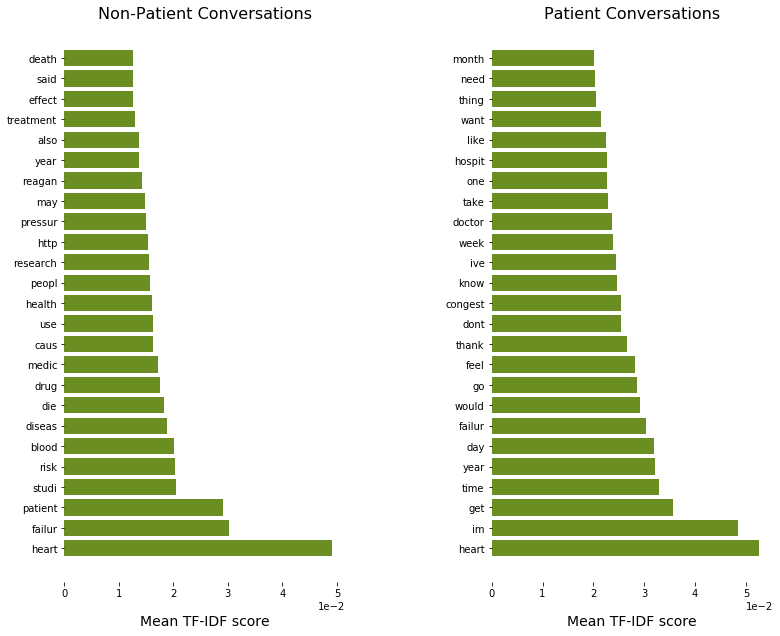

In [186]:
create_horizontal_barplot(mean_scores_0, mean_scores_1, value_name = 'Mean TF-IDF score', color = 'olivedrab')

The high scoring words differ for each category, except for 3 words.

In [187]:
def common_element(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        return (a_set & b_set)
    else: 
        print("No common elements")
        
print('The following are the common elements:')
common_lst = common_element(mean_scores_1.index, mean_scores_0.index)
common_lst

The following are the common elements:


{'failur', 'heart', 'year'}

A function is defined that computes the number of times words appear in the 'top-10 TFIDF' scores for each document. This computation has been performed separately for each of the classes inorder to truly understand which set of words are more representative of a particular class.

In [188]:
def get_best_tfidfs(X, y, document_category = 1):
    for elem in y_train:
        index_list = [i for i in range(len(y_train)) if y[i] == document_category] 
    top50_lst =[]
    for idx in index_list:
        temp_df = pd.DataFrame(X[idx], index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"+str(idx)])
        top50_lst.append(temp_df.nlargest(10,"tfidf"+str(idx)).index)
    top50_lst = np.array(top50_lst)
    top50_lst = top50_lst.ravel()
    (values,counts) = np.unique(top50_lst, return_counts=True)
    count_df = pd.DataFrame()
    count_df['values'] = values
    count_df['Number of docs where word is high scoring'] = counts
    count_df = count_df.nlargest(25, 'Number of docs where word is high scoring')
    count_df = count_df.set_index('values')
    return count_df


In [189]:
count_0 = get_best_tfidfs(X_train, y_train, document_category = 0)
count_1 = get_best_tfidfs(X_train, y_train, document_category = 1)

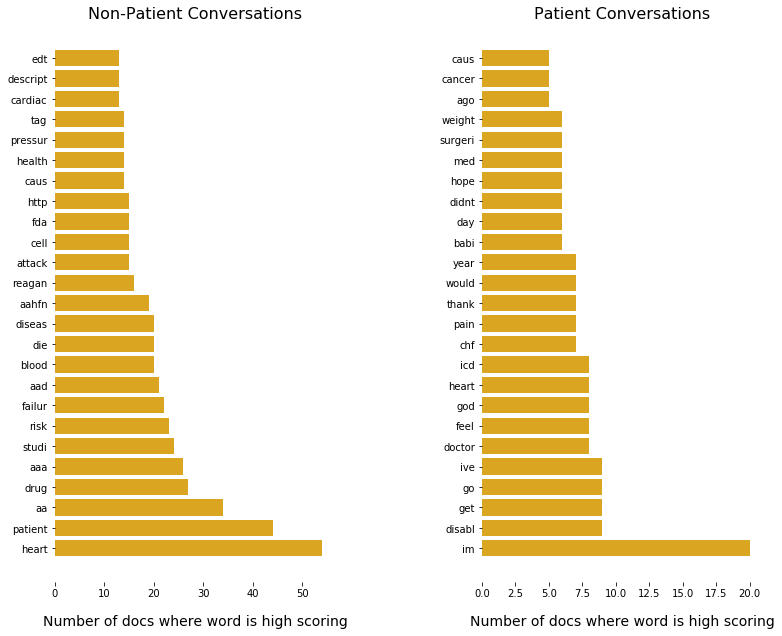

In [190]:
create_horizontal_barplot(count_0, count_1, value_name = 'Number of docs where word is high scoring', color = 'goldenrod')

In [191]:
common_lst = common_element(count_0.index, count_1.index)
print('The following are the common elements:')
common_lst

The following are the common elements:


{'caus', 'heart'}

It can be observed that certain set of words represent one class more than the other. The TFIDF scores quantifies these representations. The purpose of the above analysis was to ascertain that TFIDF scores have helped differentiate between the two classes. The prominent features for both classes differ significantly. In the next steps, we choose our classifier based on the above finding.

# 4. Feature Engineering and Modelling

NLP tasks comprise of high dimensional but sparse feature vectors. In our case, each class has almost completely different set of important features, thus the positive and negative samples would be distributed in completely different regions of the high dimensional feature space. Thus, we expect our classes to be linearly separable. Using a linear kernel for the SVM classifier should suffice for our problem.

## 4.1 Iteration-1

Stratified K-Fold Cross-Validation is used to maintain the original train, test ratio for each individual split. To prevent the inclusion of the validation data for the purpose of modelling, it is necessary that our Tfidf vectorizer fits only on the train set, a pipeline has been created that performs the Tfidf vector formation and also fits the classifier object. Using the pipeline ensures that the validation data doesn't leak into the Tfidf vectorizer results. The evaluation metrics obtained would be the mean of the evaluation metric for all splits.

In [199]:
def cross_val_iter1(X, y, scoring_lst):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    pipeline = make_pipeline(TfidfVectorizer(), svm.SVC(C=1, kernel='linear'))
    scores = cross_validate(pipeline, X, y, scoring=scoring_lst, cv=cv, n_jobs=-1)
    return round(np.mean(scores['test_accuracy']),4), round(np.mean(scores['test_precision']),4), round(np.mean(scores['test_recall']),4), round(np.mean(scores['test_f1']),4)
    

In [200]:
print('Iteration-1:')
summary_scores_df = pd.DataFrame()
summary_scores_df['Metric'] = ['Accuracy', 'Precision', 'Recall', 'F1 Score' ]
summary_scores_df['Initial results (No sampling)'] = cross_val_iter1(X,y, ['accuracy', 'precision', 'recall','f1'])
summary_scores_df

Iteration-1:


,Metric,Initial results (No sampling)
0,Accuracy,0.8925
1,Precision,0.7948
2,Recall,0.6583
3,F1 Score,0.7145


Since the dataset is highly imbalanced, the accuracy score is highly misleading and is not the right metric to observe. The low recall score indicates that the model isn't performing well on the positive samples, i.e due to less data availability for the positive samples, the model has been trained insufficiently.

## 4.2 Iteration-2

Inorder to improve the performance of the model on the positive samples, it is necessary to have more
data points for it and reduce the imbalance in the dataset. 
Oversampling is a way to synthetically generate data samples for the minority class so as to ensure better balance in our data. These samples are generated through different techniques by finding K nearest neighbours for each sample in the minority class and generating a new sample between these neighbours (SMOTE). Random Sampling of points in the minority class is another way to oversample. Let's analyze the performance after performing these operations. It is to be noted that the oversampling technique would be part of the pipeline.

In [201]:
def cross_val_iter2(X, y, scoring_lst, oversampling_technique):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    if oversampling_technique is 'SMOTE':
        pipeline = Pipeline([('tfidf',TfidfVectorizer()),('smote',SMOTE(random_state=42)), ('svm',svm.SVC(C=1, kernel='linear'))])
    elif oversampling_technique is 'Random':
        pipeline = Pipeline([('tfidf',TfidfVectorizer()),('random_sampler',RandomOverSampler(random_state=42)), ('svm',svm.SVC(C=1, kernel='linear'))])
    scores = cross_validate(pipeline, X, y, scoring=scoring_lst, cv=cv, n_jobs=-1)
    return round(np.mean(scores['test_accuracy']),4), round(np.mean(scores['test_precision']),4), round(np.mean(scores['test_recall']),4), round(np.mean(scores['test_f1']),4)
    

In [202]:
print('Iteration-2:')
summary_scores_df['Random'] = cross_val_iter2(X,y, ['accuracy', 'precision','recall', 'f1'], oversampling_technique = 'Random')
summary_scores_df['SMOTE'] = cross_val_iter2(X,y, ['accuracy', 'precision','recall', 'f1'], oversampling_technique = 'SMOTE')
summary_scores_df

Iteration-2:


,Metric,Initial results (No sampling),Random,SMOTE
0,Accuracy,0.8925,0.8966,0.8954
1,Precision,0.7948,0.7748,0.7744
2,Recall,0.6583,0.7139,0.7083
3,F1 Score,0.7145,0.7396,0.7362


From the above table we can clearly see that oversampling the data does improve the model performance on positive samples. A tradeoff always exists between the precision and recall, the F1 score characterizes this trade-off with a metric by taking their harmonic mean. An improvement in F1-score is also observed after oversampling.

## 4.3 Iteration-3
After oversampling an improvement in performance was observed since the model learnt to recognize the minority class better. However, the model weights are still overly biased towards the majority class because of the large number of original samples of it present in the data. The goal for this iteration is to make sure that the bias towards the majority class is reduced. This can be performed by slightly oversampling the minority class first and then undersampling the majority class. 

Note: The sampling strategy is set to 0.3 for the oversampling phase because we already have an initial balance ratio 0.2 in our dataset. 

In [203]:
def cross_val_iter3(X, y, scoring_lst, oversampling_technique):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    if oversampling_technique is 'SMOTE':
        pipeline = Pipeline([('tfidf',TfidfVectorizer()),('smote',SMOTE(sampling_strategy = 0.3,random_state=42)), ('random_undersampler',RandomUnderSampler(sampling_strategy = 0.5, random_state=42)), ('svm',svm.SVC(C=1, kernel='linear'))])
    elif oversampling_technique is 'Random':
        pipeline = Pipeline([('tfidf',TfidfVectorizer()),('random_oversampler',RandomOverSampler(sampling_strategy = 0.3, random_state=42)), ('random_undersampler',RandomUnderSampler(sampling_strategy = 0.5, random_state=42)),('svm',svm.SVC(C=1, kernel='linear'))])

    scores = cross_validate(pipeline, X, y, scoring=scoring_lst, cv=cv, n_jobs=-1)
    return round(np.mean(scores['test_accuracy']),4), round(np.mean(scores['test_precision']),4), round(np.mean(scores['test_recall']),4), round(np.mean(scores['test_f1']),4)
    

In [204]:
print('Iteration 3:')
summary_scores_df['SMOTE+Undersampling'] = cross_val_iter3(X,y, scoring_lst = ['accuracy', 'precision','recall', 'f1'], oversampling_technique = 'SMOTE')
summary_scores_df['Random+Undersampling'] = cross_val_iter3(X,y, scoring_lst = ['accuracy', 'precision','recall', 'f1'], oversampling_technique = 'Random')
summary_scores_df

Iteration 3:


,Metric,Initial results (No sampling),Random,SMOTE,SMOTE+Undersampling,Random+Undersampling
0,Accuracy,0.8925,0.8966,0.8954,0.8971,0.8971
1,Precision,0.7948,0.7748,0.7744,0.7524,0.7539
2,Recall,0.6583,0.7139,0.7083,0.7611,0.7597
3,F1 Score,0.7145,0.7396,0.7362,0.7537,0.7534


In [206]:
summary_scores_df[['Metric','Initial results (No sampling)', 'SMOTE+Undersampling']]

,Metric,Initial results (No sampling),SMOTE+Undersampling
0,Accuracy,0.8925,0.8971
1,Precision,0.7948,0.7524
2,Recall,0.6583,0.7611
3,F1 Score,0.7145,0.7537


An increase from 0.6583 to 0.7611 in the recall has been observed due to sampling, around 16 %.
Although the precision has suffered, an approximately 5.5% increase in the f1-score indicates that the overall performance has improved and the tradeoff was worth it.